# Chap03 - MCMC 블랙박스 열기

## 3.1 베이지안 지형

베이지안 추론을 위해서는 **MCMC(Markov Chain Monte Carlo)**를 다루어야만 한다. MCMC과정을 알면 알고리즘의 수렴 여부를 알 수 있다. 또한, 우리가 1, 2장에서 살펴보았던 모델링 후 수천 개의 사후확률표본을 돌려받는 이유를 이해할 수 있다.

미지수가 $N$개인 베이지안 추론 문제를 설정할 때 암묵적으로 기존에 있는 사전확률분포를 위한 $N$차원 공간을 만든다. 공간과 관련된 것이 추가 차원인데, **표면**(surface) 또는 **곡선**(curve)라고 하며, 특정한 위치의 **사전확률을**을 반영하는 공간의 상단(?)을 말한다. 공간 위 표면은 사전확률분포로 정의된다. 

예를 들어 미지수 $p_1$과 $p_2$가 있고 둘의 사전확률분포가 $\text{Uniform}(0,5)$라면 만들어진 공간은 한 변의 길이가 $5$인 정사각형이고 표면은 그 정사각형이고 표면은 그 정사각형 위에 있는 평면이다. 여기서 균등 사전확률분포를 선택했기 때문에 모든 점의 확률이 같음을 나타낸다.

In [1]:
%matplotlib inline 
import numpy as np
import matplotlib
import scipy.stats as stats

from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# matplotlib.rc('font', family='NanumGothic')  # linux
matplotlib.rc('font', family='AppleGothic')  # Mac OS

figsize(12, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

Text(0.5,0.92,'균등 사전확률분포로 구성한 다른 방향의 모습')

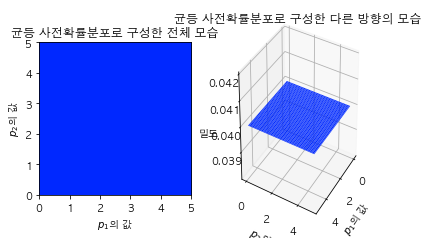

In [2]:
jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_y[:, None], uni_x[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('$p_1$의 값')
plt.ylabel('$p_2$의 값')
plt.title('균등 사전확률분포로 구성한 전체 모습')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
ax.set_xlabel('$p_1$의 값')
ax.set_ylabel('$p_2$의 값')
ax.set_zlabel('밀도')
plt.title('균등 사전확률분포로 구성한 다른 방향의 모습')

만약, 두 사전확률분포가 $\text{Exp}(3)$과 $\text{Exp}(10)$이라면 공간은 2차원 평면에서 모두 양수다. 아래의 그림은 색상이 어두운 빨간색일수록 그 위치에 더 많은 사전확률이 할당된 것이다. 어두운 파란색일수록 그 위치에 할당된 사전확률은 매우 작다.

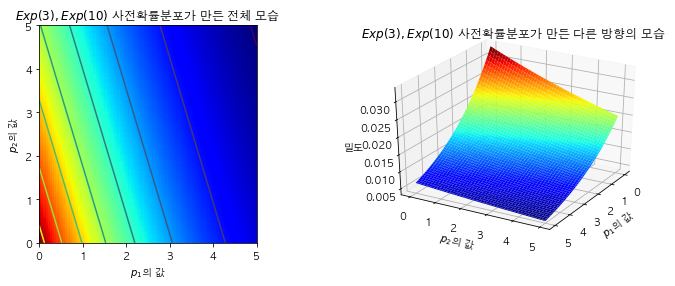

In [3]:
figsize(12, 4)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_y[:, None], exp_x[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.xlabel("$p_1$의 값")
plt.ylabel("$p_2$의 값")
plt.title("$Exp(3), Exp(10)$ 사전확률분포가 만든 전체 모습")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
ax.set_xlabel( "$p_1$의 값" )
ax.set_ylabel( "$p_2$의 값" )
ax.set_zlabel( "밀도" )
plt.title("$Exp(3), Exp(10)$ 사전확률분포가 만든 다른 방향의 모습");

위에서 본 그래프들은 확률공간의 사전확률분포에 대한 표면(surface)을 나타낸다. 

> **여기에 (관측) 데이터 $X$를 포함시키면 어떤일이 일어날까?**

데이터 $X$는 공간을 변화시키지는 않지만, 사전확률 **표면을 변화**(당기거나, 늘림)시켜 모수가 존재하는 위치를 반영한다.

- 데이터가 많을수록 표면의 변화가 크다.
- 변화된 표면은 새로운 **사후확률분포**를 보여준다.



미지의 모수 $\lambda$를 가진 두 푸아송분포를 추론한다고 가정하고, 균등 사전확률분포와 지수 사전확률분포를 사용하여 두 미지수 $\lambda$를 비교해보자. 

In [4]:
# 관측 데이터를 만든다.
# 관측 데이터의 크기 (N= 1 ~ 100)
N = 1

# 실제 모수 (가정)
lambda_1_true = 1
lambda_2_true = 3

# 위의 두 모수에 종속적인 데이터를 생성
data = np.concatenate([
        stats.poisson.rvs(lambda_1_true, size=(N, 1)),
        stats.poisson.rvs(lambda_2_true, size=(N, 1))], axis=1)
print('observed (2-dimensional, sample size = %d:)' % N, data)

x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                         for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 0], _y)
                         for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

observed (2-dimensional, sample size = 1:) [[1 2]]


(0, 5)

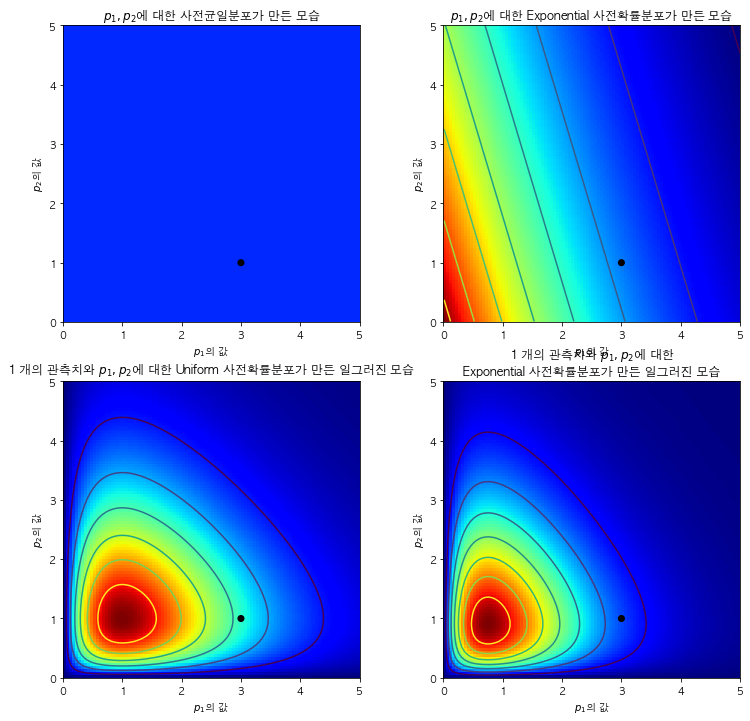

In [5]:
figsize(12.5, 12)

# matplotlib에 부하가 걸리는 작업
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_y[:, None], uni_x[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("$p_1$의 값")
plt.ylabel("$p_2$의 값")
plt.title("$p_1, p_2$에 대한 사전균일분포가 만든 모습")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.xlabel("$p_1$의 값")
plt.ylabel("$p_2$의 값")
plt.title("\n%d 개의 관측치와 $p_1, p_2$에 대한 Uniform 사전확률분포가 만든 일그러진 모습" % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_y[:, None], exp_x[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("$p_1$의 값")
plt.ylabel("$p_2$의 값")
plt.title("$p_1, p_2$에 대한 Exponential 사전확률분포가 만든 모습")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
# 이것은 사전적인 우도  함수, 결과는 사후적임
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlabel("$p_1$의 값")
plt.ylabel("$p_2$의 값")
plt.title("\n%d 개의 관측치와 $p_1, p_2$에 대한 \nExponential 사전확률분포가 만든 일그러진 모습" % N)
plt.xlim(0, 5)
plt.ylim(0, 5)

위의 각 그래프에서 검은 점은 우리가 가정한 진짜 모수를 나타낸다. 왼쪽 아래의 그림은 $\text{Uniform}(0,5)$의 사전확률을 가진 변형된 지형이다. 오른쪽 아래의 그림은 $\text{Exp}(3)$과 $\text{Exp}(10)$의 사전확률분포를 가진 변형된 지형이다. 두 경우 관측 데이터가 같아도 사후 지형은 다르게 보인다.

### 3.1.1 MCMC를 사용하여 지형 탐색하기

위에서 살펴본 것과 같이 사전확률분포의 표면과 관측 데이터가 만들어낸 변형된 사후적인 공간을 탐색하여 사후확률분포를 찾아야 한다. 

**MCMC**를 이용하여 사후확률분포를 찾는 과정에 대해 알아보자.

MCMC는 분포 자체가 아닌 사후확률분포의 **표본(sample)**을 돌려준다는 것을 기억해야 한다.

> *MCMC는 "내가 발견한 이 조약돌(samples)이 내가 찾으려는 산(posterior)에서 나올 가능성이 얼마나 될까?"라고 반복적으로 묻는 것과 유사한 작업을 수행한다.*

MCMC와 PyMC 에서 돌려받는 일련의 '조약돌'을 표본(sample), 누적되면 이를 **트레이스(trace)**라고 한다.

MCMC는 이웃한 위치를 탐색하고 확률이 높은 영역으로 이동함으로써 사후확률이 높은 영역으로 수렴(converge)한다. 

#### 수천 개의 표본이 필요한 이유

1. 사후확률에 대한 수학 공식을 돌려주는 것은 쉽지 않기 때문이다.
2. 지형의 정상(위의 그래프에서 붉은 부분)을 돌려준느 것은 가능하지만, 지형의 형태를 무시하는 방법이다.

표본을 돌려주는 가장 큰 이유는 **큰 수의 법칙**(Law of Large Number)을 사용하는 것이 쉽기 때문이다. 큰 수의 법칙은 큰 모집단에서 무작위로 뽑은 표본의 평균이 전체 모집단의 평균과 가까울 가능성이 높다는 통계와 확률 분야의 기본 개념이다.

### 3.1.2 MCMC 수행 알고리즘

MCMC를 수행하는 대부분의 알고리즘은 다음과 같이 나열할 수 있다.

1. 현재 위치에서 시작한다.
2. 새로 이동할 위치를 조사한다. → 주변의 sample을 조사
3. 데이터와 사전확률분포에 따른 위치를 바탕으로 새로운 위치를 수용하거나 기각한다. <br /> → sample이 해당 사후확률분포에서 나올 가능성을 조사
4. (a) 수용한다면 새로운 위치로 이동하고 1단계로 돌아간다. <br /> 
(b) 그렇지 않으면 이동하지 말고 1단계로 돌아간다.
5. 수많은 반복 후에 모든 가능성 위치 즉, sample들을 돌려준다.

위의 방법으로 사후확률분포가 존재하는 지역을 향해 이동하고, 이동중에 표본을 수집한다. 사후확률분포에 도달하면 표본을 쉽게 모을 수 있다.

만약 MCMC 알고리즘의 현재 위치가 극도로 낮은 확률 영역(초반, 랜덤한 위치)일 경우, 다른 위치로 이동할 가능성이 크다. 따라서, 알고리즘의 첫 이동은 사후확률분포를 반영하지 않는다. 

MCMC 알고리즘에서 가장 중요한 속성은 **비기억성(memorylessness)**이다. 비기억성이란 현재 위치에 어떻게 도착했는지에는 관심이 없고 오직 현재 위치만 중요하다는 것을 의미한다. 따라서, 새로운 위치는 현재 위치를 파악하는데 도움을 주지만, 현재 위치에 어떻게 왔는지를 아는것은 도움이 되지 않는다.

*3.1.3 생략*

### 3.1.4 예제: 혼합모델을 사용한 비지도 클러스터링

다음과 같은 데이터셋이 주어졌다고 가정해보자.

[ 115.85679142  152.26153716  178.87449059  162.93500815  107.02820697
  105.19141146  118.38288501  125.3769803   102.88054011  206.71326136] ...


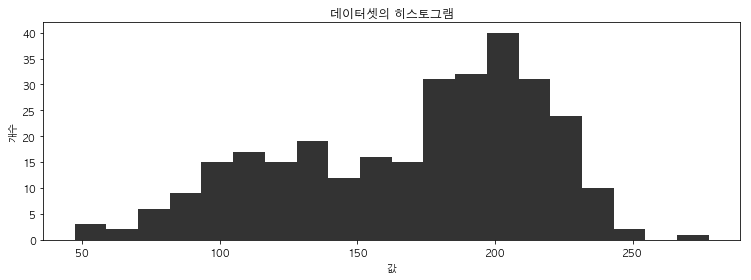

In [6]:
figsize(12.5, 4)
data = np.loadtxt('data/mixture_data.csv', delimiter=',')

plt.hist(data, bins=20, color='k', histtype='stepfilled', alpha=0.8)
plt.title('데이터셋의 히스토그램')
plt.xlabel('값')
plt.ylabel('개수')
plt.ylim([0, None])
print(data[:10], "...")

위의 그래프에서 데이터 형태는 이중형(bimodal form), $120$과 $200$ 근처에서 꼭대기가 두 개인 모습처럼 보인다. 이 데이터셋에는 **클러스터가 두 개**있을 수 있다.

이 데이터셋을 아래의 알고리즘으로 모델링 해보자

1. 각 데이터 포인트에 대해 $p$의 확률을 가진 클러스터 1을 선택하거나 클러스터 2를 선택한다.
2. 1단계에서 선택한 클러스터의 모수가 $u_i$와 $\sigma_i$인 정규확률분포에서 확률변수를 뽑는다.
3. 반복한다.

여기서 $p$나 정규확률분포의 모수를 모르므로, 추론하거나 알아내야 한다.

정규확률분포를 $\text{Nor}_0$와 $\text{Nor}_1$로 표기하자. 이 둘은 각각 미지의 평균과 표준편차, $\mu_i$와 $\sigma_i$ ($i=0, 1$)을 가진다. 

특정 데이터 포인트는 $\text{Nor}_0$이나 $\text{Nor}_1$에서 나올 수 있다. 클러스터1($\text{Nor}_0$을 따르는)의 **사전확률**은 우리가 모르기 때문에 모델링하기 위해 0과 1사이의 균등 확률변수를 만들고 이를 $p$라고 하자.

`PyMC`모듈의 `Categorical`를 이용하여 클러스터에 데이터 포인트를 할당해보자. 

In [7]:
import pymc as pm

In [8]:
# ??pm.Categorical
p = pm.Uniform('p', 0, 1)

# pm.Categorical(name, p, size)의 두번째 arg인 p는
# 리스트 형태로 입력할 수 있으며 k개의 확률변수를 가진다.
# 각 확률을 더하면 1이된다. (p + 1-p = 1)
# value속성은 0 ~ (k-1)로 출력된다.
assignment = pm.Categorical('assignment', [p, 1-p], size=data.shape[0])
print('prior assignment, with p = %.2f:' % p.value)
print(assignment.value[:10], '...')

prior assignment, with p = 0.64:
[0 1 1 0 0 1 1 0 0 0] ...


위의 데이터셋에서 두 정규확률분포의 표준편차가 다르다는 것을 알 수 있다.(?) 표준편차 또한 모르기 때문에 0과 100 사이의 균등 확률분포로 표준편차를 모델링한다.

$$
\sigma_i \sim \text{Uniform}(0, 100) \quad i=0, 1
$$

표준편차를 이용하여 정규확률분포의 **정밀도(precision)** $\tau$를 구해보자.

$$
\tau = \frac{1}{\sigma^2}
$$

<br />
![](./images/nor-precision.png)

In [9]:
# precision of Normal Distribution
# size=2인 이유는 sigma_1, sigma_2를 
# 모델링해야 하기 때문이다.
# taus = 1.0 / pm.Uniform('stds', 0, 100, size=2) ** 2

이번엔 클러스터의 중심에 대한 사전확률을 구체화 한다. 중심은 실제 정규확률분포에서 모수 $\mu$ 다. 위의 데이터셋 그래프에서 두 개의 중심이 어디에 있는지 짐작한다. 각각 $\mu_0 = 120, \mu_1 = 190$로 설정하고, $\sigma_{0,1}=10$으로 설정하자. ($\tau = \frac{1}{\sigma^2} = 0.01$이 된다.)

In [10]:
# 책의 설명과 코드가 다른듯함
taus = 1.0 / pm.Uniform("stds", 0, 100, size=2) ** 2
centers = pm.Normal('centers', [120, 190], [0.01, 0.01], size=2)

'''
아래의 deterministic 함수마다 할당이 주어진다. 
0 또는 1인 경우 (1,2) 배열 'taus'와 'centers'에 위치한 
모수의 집합에 할당이 주어진다.
'''

@pm.deterministic
def center_i(assignment=assignment, centers=centers):
    return centers[assignment]

@pm.deterministic
def tau_i(assignment=assignment, taus=taus):
    return taus[assignment]

print('Random assignments: ', assignment.value[:4], '...')
print('Assigned center: ', center_i.value[:4], '...')
print('Assigned precision: ', tau_i.value[:4], '...')

Random assignments:  [0 1 1 0] ...
Assigned center:  [ 143.24964254  225.40981765  225.40981765  143.24964254] ...
Assigned precision:  [ 0.00013316  0.00103458  0.00103458  0.00013316] ...


In [11]:
# 관측치와 결합
observations = pm.Normal('obs', center_i, tau_i, value=data, observed=True)

# 모델 클래스를 만든다.
model = pm.Model([p, assignment, observations, taus, centers])

`PyMC`는 `MCMC` 클래스를 가지고 있으며, MCMC 탐색 알고리즘을 구현한 것이다.

MCMC가 공간을 탐색하도록 요청하는 메소드는 `pm.sample(iterations)`이다. 여기서 `iterations`는 알고리즘 반복 횟수이다. 아래의 코드는 $50,000$번 반복한다.

In [12]:
mcmc = pm.MCMC(model)
mcmc.sample(50000)

 [-----------------100%-----------------] 50000 of 50000 complete in 13.7 sec

MCMC의 **트레이스**(탐색한 경로)를 알아보자. 아래의 그래프는 미지의 모수(중심, 표준편차, $p$)의 트레이스 값들이다. 

`MCMC` 객체의 `trace`메소드를 이용하여 가져올 수 있으며, 변수이름을 매개변수로 받는다.

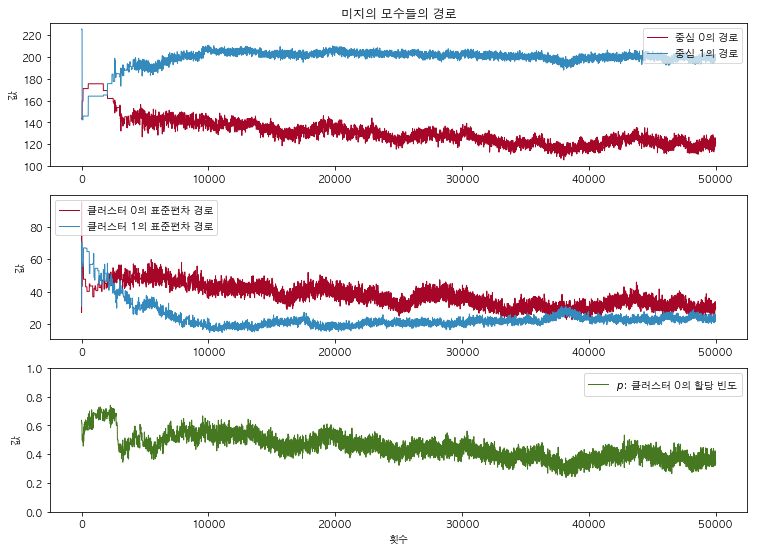

In [13]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = mcmc.trace('centers')[:]

colors = ["#348ABD", "#A60628"] \
if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="중심 0의 경로", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="중심 1의 경로", c=colors[1], lw=lw)
plt.ylabel("값")
plt.title("미지의 모수들의 경로")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = mcmc.trace("stds")[:]
plt.plot(std_trace[:, 0], label="클러스터 0의 표준편차 경로",
         c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="클러스터 1의 표준편차 경로",
         c=colors[1], lw=lw)
plt.ylabel("값")
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = mcmc.trace("p")[:]
plt.plot(p_trace, label="$p$: 클러스터 0의 할당 빈도",
         color="#467821", lw=lw)
plt.xlabel("횟수")
plt.ylabel("값")
plt.ylim(0, 1)
plt.legend();

위의 그림에서 특징들을 확인해보자.

1. 경로는 수렴하는거처럼 보이나, 하나의 점으로 수렴하는 것이 아니라 가능한 점들의 **분포**로 수렴한다. <br />
→ MCMC 알고리즘의 **수렴**
2. 알고리즘 초반의 샘플을 사용한 추론은 좋지 않다. 우리가 구하고자 하는 최종 분포와는 상관이 없기 때문이다. <br />따라서, 초반의 표본들을 버리는 것이 좋다. 수렴 이전의 이런 기간을 **번인 기간**(burn-in period)라고 한다.
3. 경로는 공간에서 **랜덤 '워크'**로 나타난다. 경로는 바로 직전의 이전 위치와 상관관계를 보인다. 

In [14]:
# 이미 MCMC가 호출된 이후 
# 다시 MCMC를 시작해도 처음부터 시작하지 않는다.
mcmc.sample(100000)

 [-----------------100%-----------------] 100000 of 100000 complete in 27.2 sec

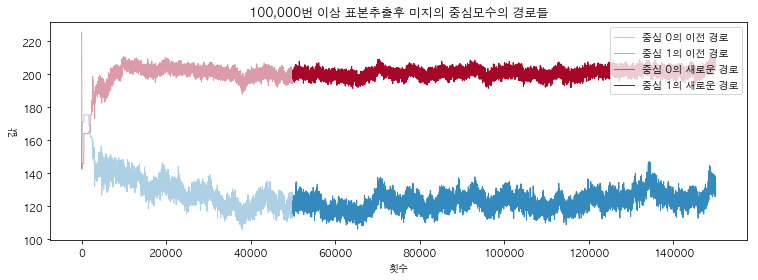

In [15]:
figsize(12.5, 4)

#####
# chain : int
# - The trace index. Setting `chain=i` will return the trace 
#   created bythe ith call to `sample`.
######
center_trace = mcmc.trace("centers", chain=1)[:]
prev_center_trace = mcmc.trace("centers", chain=0)[:]

x = np.arange(50000)
plt.plot(x, prev_center_trace[:, 0], label="중심 0의 이전 경로",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="중심 1의 이전 경로",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(50000, 150000)
plt.plot(x, center_trace[:, 0], label="중심 0의 새로운 경로", lw=lw, c="#348ABD")
plt.plot(x, center_trace[:, 1], label="중심 1의 새로운 경로", lw=lw, c="#A60628")

plt.title("100,000번 이상 표본추출후 미지의 중심모수의 경로들")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("횟수")
plt.ylabel("값");

#### 클러스터 조사

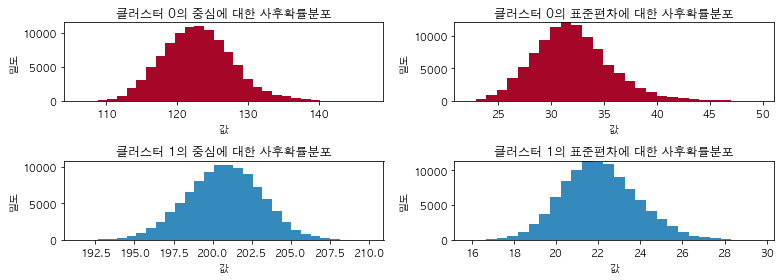

In [16]:
figsize(11.0, 4)
std_trace = mcmc.trace("stds")[:]

_i = [1, 2, 3, 4]

for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("클러스터 %d의 중심에 대한 사후확률분포" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    plt.xlabel("값")
    plt.ylabel("밀도")
    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("클러스터 %d의 표준편차에 대한 사후확률분포" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    plt.xlabel("값")
    plt.ylabel("밀도")
    plt.autoscale(tight=True)

plt.tight_layout()

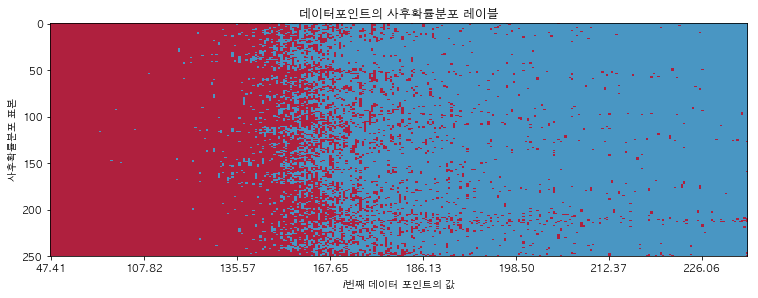

In [17]:
import matplotlib as mpl
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(mcmc.trace("assignment")[::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("사후확률분포 표본")
plt.xlabel("$i$번째 데이터 포인트의 값")
plt.title("데이터포인트의 사후확률분포 레이블");

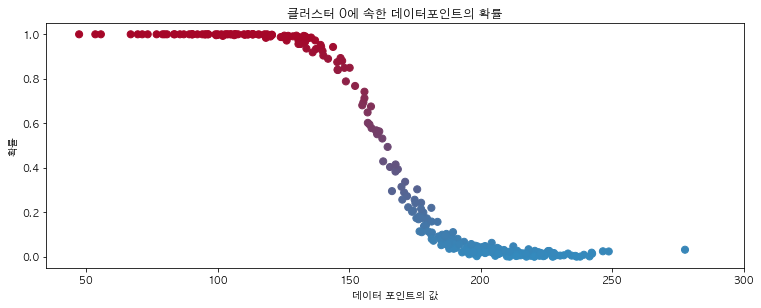

In [18]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = mcmc.trace("assignment")[:]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("클러스터 0에 속한 데이터포인트의 확률")
plt.ylabel("확률")
plt.xlabel("데이터 포인트의 값");

이렇듯 정규분포를 사용하여 클러스터를 모델링했지만, 데이터에 **가장** 잘 맞는 하나의 정규분포를 얻지 못하고 정규분포의 모수 값에 대한 분포만 얻었다. 

> *어떻게 평균과 분산 한 쌍을 선택하여 **최적합** 가우시안을 알 수 있을까?*

한 가지 방법으로는 사후확률분포의 **평균**을 사용하는 것이다. 

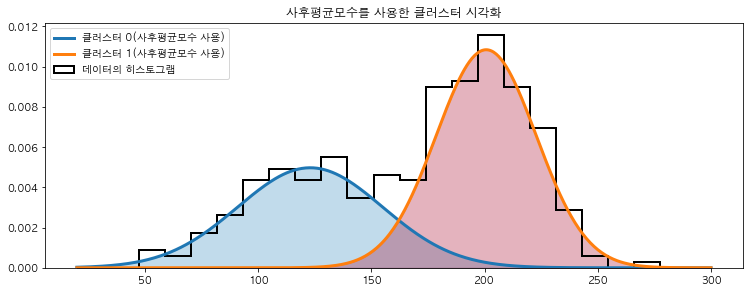

In [19]:
norm = stats.norm
x = np.linspace(20, 300, 500)

# 우리가 추론한 사후확률의 평균 계산
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = mcmc.trace("p")[:].mean()

plt.hist(data, bins=20, histtype="step", density=True, color="k",
     lw=2, label="데이터의 히스토그램")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="클러스터 0(사후평균모수 사용)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="클러스터 1(사후평균모수 사용)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("사후평균모수를 사용한 클러스터 시각화");

### 3.1.5 사후확률분포의 표본을 섞지 마라

위의 그림에서 가능한 시나리오는 클러스터 0은 상대적으로 큰 표준편차를 가지고, 클러스터 1은 작은 표준편차를 가지는 것이다. 

두 분포 모두 작은 표준편차를 가질 가능성은 작다. 두 표준편차는 서로에게 **종속적**이라고 할 수 있다. 한 쪽이 작으면 다른 쪽은 커야하기 때문이다.

우리는 MCMC를 통해 미지의 사후확률분포의 표본 벡터를 돌려 받는다. 

아래의 예제를 보자. 두 변수 $x$와 $y$가 1차식 $x+y=10$으로 연관되어 있다. $x$를 평균이 $4$인 정규확률변수로 모델링하고, 표본 500개를 탐색해보자.

 [-----------------100%-----------------] 500 of 500 complete in 0.0 sec

Text(0.5,1,'미지수 간 종속성(극단의 사례)')

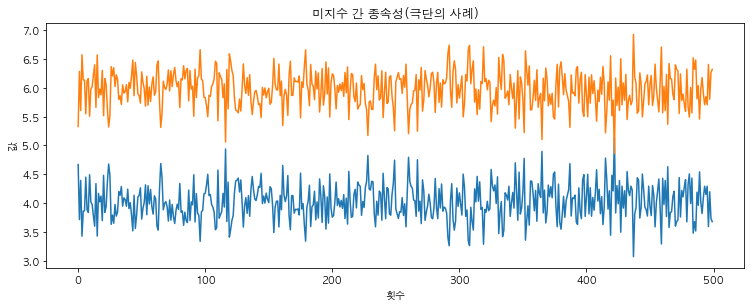

In [20]:
x = pm.Normal('x', 4, 10)
y = pm.Lambda('y', lambda x=x: 10-x, trace=True)

ex_mcmc = pm.MCMC(pm.Model([x, y]))
ex_mcmc.sample(500)

plt.plot(ex_mcmc.trace('x')[:])
plt.plot(ex_mcmc.trace('y')[:])
plt.xlabel('횟수')
plt.ylabel('값')
plt.title('미지수 간 종속성(극단의 사례)')

#### 클러스터로 돌아와서: 예측

예를 들어 $x=175$를 클러스터에 레이블링 즉, 분류하고자 한다. 이때, 단순히 데이터 포인트를 클러스터의 중심 가까이에 할당하는 것은 좋지 못하다. 그 이유는 클러스터의 표준편차를 고려하지 않는 것이기 때문이다. 

따라서, $x=175$를 클러스터 1에 할당하는 **확률**을 구한다. $x$를 할당한 것을 $L_x$라고 하자. $L_x$는 0 또는 1이다. 그리고 우리가 구하고자 하는 확률을 $P(L_x = 1 | x=175)$이다.

이를 계산하는 방법은 단순하게 추가된 데이터 포인트를 가지고 `MCMC`를 재실행하는 것이다. 하지만, 이 방법은 추론이 느리다는 단점이 있다. 

대안으로 정밀도는 떨어지지만 훨씬 빠른 방법인 베이즈 정리(Bayes Theorem)을 사용한다. 

$$
P(A|X) = \frac{P(X|A)P(A)}{P(X)}
$$

위의 식에서 $A$sms $L_x = 1$을 나타내고 $X$는 관측 데이터 $X=175$이다. 우리가 추론한 ($\mu_0, \sigma_0, \mu_1, \sigma_1, p$)의 특정 표본집합에 대해 

> $X$가 클러스터 1에 존재할 확률이 클러스터 0에 존재할 확률보다 높은가? 

$$
P(L_x = 1 | x= 175) > P(L_x =0 | x=175)
$$

$$
\frac{P(x=175 | L_x =1)P(L_x=1)}{P(x=175)} > \frac{P(x=175|L_x=0)P(L_x=0)}{p(x=175)}
$$

분모가 같으므로 다음과 같이 표현할 수 있다.

$$
P(x=175 | L_x =1)P(L_x=1) > P(x=175|L_x=0)P(L_x=0)
$$

In [21]:
norm_pdf = stats.norm.pdf
p_trace = mcmc.trace('p')[:]
x = 175

v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])

print("클러스터 1에 속할 확률:", v.mean())

클러스터 1에 속할 확률: 0.01224


In [22]:
v.shape

(100000,)

### 3.1.6 MAP을 사용하여 수렴 개선하기

위의 예제를 실행해보면 결과가 일관적이지 않다는 것을 알 수 있다. 그 이유는 MCMC 알고리즘의 **시작값**에 영향을 받기 때문이다. 

만약 MCMC를 충분히 오래 실행하여 많은 단계를 수행하는 경우, 그 알고리즘의 **최초 포지션을 잊게 된다**. 즉, MCMC가 수렴함을 의미한다. 따라서, MCMC가 완전히 수렴하지 않는 경우, MCMC의 표본을 사용하면 안된다. 

이상적인 시작값은 확률분포표면의 지형 정상에서 시작하는 것이다. 그래야지 번인 기간과 잘못된 추론을 피할 수 있다. 이러한 정상을 **최대사후확률**(**MAP**, Maximum A Posterior)이라 한다.

`PyMC`모듈에서 `MAP.fit()`을 이용해 최대사후확률을 구할 수 있다.

```python
map_ = pm.MAP(model)
map_.fit()
#  = pm.MAP(model).fit()
```

`fit()` 메소드 호출 시 기본 최적화 아록리즘은 `SciPy`의 `fmin`알고리즘이다. `PyMC`에서는 `fit(method='fmin_powell')` 이다. 이 알고리즘은 수렴이 느리거나 보장되지 않는 경우 실험적으로 파월 메서드를 사용한다. 



#### 번인 기간

`MCMC.sample`을 호출하면서 `MAP` 사전확률을 사용하더라도 안전하게 번인 기간을 두는 것이 좋다. 

In [23]:
model = pm.Model([p, assignment, taus, centers])

map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)
mcmc.sample(100000, 50000)

/Users/cjh/miniconda3/envs/study/lib/python3.6/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)


 [-----------------100%-----------------] 100000 of 100000 complete in 25.8 sec

## 3.2 수렴 판정하기

### 3.2.1 자기상관

**자기상관(autocorrelation)**은 시계열이 자신과 얼마나 상관되어 있는가를 보여주는 척도다. 

- 측정값 $1$은 완전한 양의 자기상관
- 측정값 $0$은 상관관계가 없다.
- 측정값 $-1$은 완전한 음의 상관관계

> **자기상관은 시점 $t$의 시계열 $x_t$가 시점 $x_{t-k}$와 어떻게 상관되어 있는가?**

$$
R(k) = Corr(x_t, x_{t-k})
$$

예를 들어 다음과 같은 시계열이 두 개 있다고 해보자.

$$
x_t \sim \text{Normal}(0,1), \quad x_0 = 0
$$

$$
y_t \sim \text{Normal}(y_{t-1}, 1), \quad y_0=0
$$

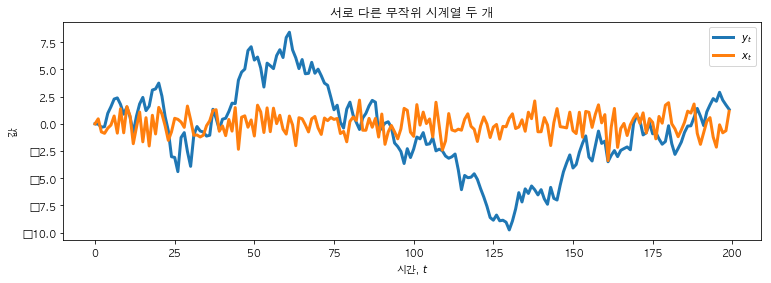

In [24]:
figsize(12.5, 4)

# import pymc as pm

x_t = pm.rnormal(0, 1, 200)
x_t[0] = 0
y_t = np.zeros(200)
for i in range(1, 200):
    y_t[i] = pm.rnormal(y_t[i-1], 1)
    
plt.plot(y_t, label='$y_t$', lw=3)
plt.plot(x_t, label='$x_t$', lw=3)
plt.xlabel('시간, $t$')
plt.ylabel('값')
plt.title('서로 다른 무작위 시계열 두 개')
plt.legend();

자기상관을 이해하는 방법 하나를 생각해보자.

> "만일 내가 시점 $s$에서 시계열의 위치를 알고 있다면 시점 $t$에서 나의 위치를 아는 데 도움이 될까?"

위의 질문에서 시계열 $x_t$는 독립확률변수이므로 도움이 되지 않는다. 

반면, $y_t$는 자기상관이다. 위의 코드에서 알 수 있듯이 만약 $y_2=10$이라면 $y_3$가 $10$에서 멀지 않은 곳에 있을 것이라고 확신할 수 있다. 하지만, 두 시점 간의 차이 $k$가 증가할수록 자기상관은 감소한다. 

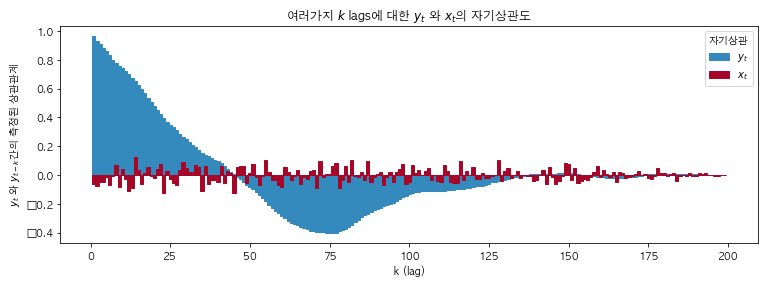

In [25]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

colors = ["#348ABD", "#A60628", "#7A68A6"]

x = np.arange(1, 200)
plt.bar(x, autocorr(y_t)[1:], width=1, label="$y_t$",
        edgecolor=colors[0], color=colors[0])
plt.bar(x, autocorr(x_t)[1:], width=1, label="$x_t$",
        color=colors[1], edgecolor=colors[1])

plt.legend(title="자기상관")
plt.ylabel("$y_t$ 와 $y_{t-k}$간의 측정된 상관관계")
plt.xlabel("k (lag)")
plt.title("여러가지 $k$ lags에 대한 $y_t$ 와 $x_t$의 자기상관도");

#### MCMC 수렴과 무슨 관계인가?

MCMC 알고리즘의 성격상 항상 자기상관관계를 보이는 표본을 얻는다. 

공간을 잘 탐색하고 있는 체인(chain)은 매우 높은 상관관계를 보여줄 것이다. 이는 MCMC에서 사후확률분포를 찾는 데 있어 문제가 된다. 그 이유는 이전의 값에 영향을 받기 때문이다.

반면에, 낮은 상관관계를 가진다면 체인이 *'잘 섞인 것(Mixing well)'* 이라 할 수 있다.

### 3.2.2 솎아내기 - Thinning

MCMC에서 사후확률분포 표본 간 높은 상관관계가 있을 경우 문제가 되므로 서로 **독립적인** 표본을 필요로 한다.

이러한 문제를 해결하거나 줄이기 위해, 매번 $n$번째 표본을 돌려주거나 자기상관을 약간 제거하는 방법이 있다. 이러한 방법을 **Thinning**이라 한다.

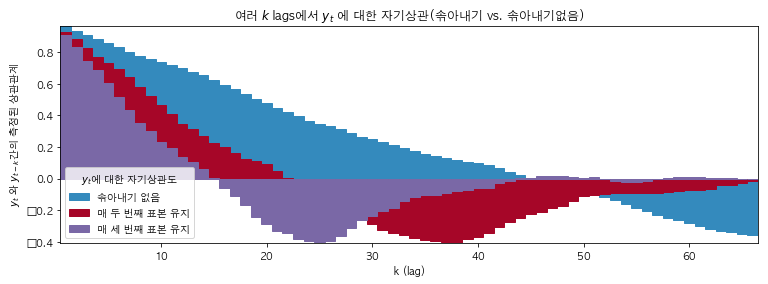

In [26]:
max_x = 200 // 3 + 1
x = np.arange(1, max_x)

plt.bar(x, autocorr(y_t)[1:max_x], edgecolor=colors[0],
        label="솎아내기 없음", color=colors[0], width=1)
plt.bar(x, autocorr(y_t[::2])[1:max_x], edgecolor=colors[1],
        label="매 두 번째 표본 유지", color=colors[1], width=1)
plt.bar(x, autocorr(y_t[::3])[1:max_x], width=1, edgecolor=colors[2],
        label="매 세 번째 표본 유지", color=colors[2])

plt.autoscale(tight=True)
plt.legend(title="$y_t$에 대한 자기상관도", loc="lower left")
plt.ylabel("$y_t$ 와 $y_{t-k}$간의 측정된 상관관계")
plt.xlabel("k (lag)")
plt.title("여러 $k$ lags에서 $y_t$ 에 대한 자기상관(솎아내기 vs. 솎아내기없음)");

위의 그래프에서 확인할 수 있듯이, Thinning이 많을수록 자기상관은 빠르게 줄어든다. 이러한 Thinning은 Trade-off가 존재하는데, 같은 수의 표본을 얻기 위해서는 MCMC를 더 많이 반복해줘야 한다. 보통 1 ~ 10 사이의 Thinning을 해준다.

### 3.2.3 `pymc.Matplot.plot()`

MCMC를 실행할 때마다 매번 `maplotlib` 모듈을 이용해 히스토그램, 트레이스등을 plotting하기 위해 코딩하는 것은 불편하고 귀찮은 일이다. 이를 위해 `PyMC`모듈에서 시각화를 지원해준다.

 [-----------------100%-----------------] 25000 of 25000 complete in 5.4 secPlotting centers_0
Plotting centers_1


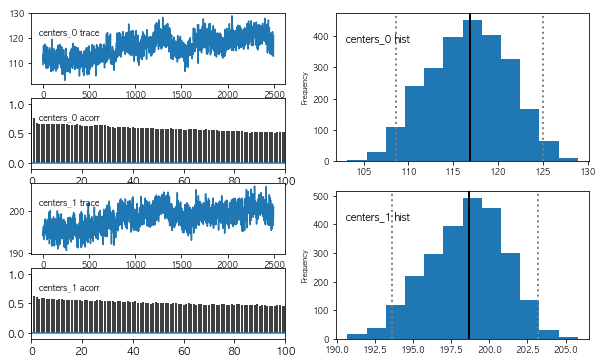

In [27]:
from pymc.Matplot import plot as mcplot

mcmc.sample(25000, 0, 10)
mcplot(mcmc.trace('centers', 2), common_scale=False)
# mcplot(mcmc.trace('stds', 2), common_scale=False)

- 위의 그래프에서 왼쪽 위 첫번째 그래프는 `centers`의 trace(경로)이다. 수렴하지 않는 'meandering' 속성을 검사하는 데 유용하다.
- 오른쪽 그래프는 표본의 히스토그램이다. 
    - 두꺼운 수직선은 사후확률분포를 잘 요약해주는 사후평균을 의미한다.
    - 두 수직점선 사이의 구간은 95% **신용구간**(credible interval)이다. 즉 '이 구간에 모수의 값이 존재할 가능성이 95% 다'라고 해석할 수 있다.
    - 왼쪽 아래의 그래프는 자기상관(autocorrelation)이다.  

## 3.3 MCMC에 대한 유용한 팁

### 3.3.1 지능적인 시작값 - Intelligent starting values

MCMC 알고리즘이 사후분포 근처에서 시작하면 정확히 표본추출하는 데 시간이 별로 걸리지 않는다. 

`PyMC`에서 `Stochastic` 변수 생성 시 `value` 매개변수를 지정함으로써 사후분포가 위치한 곳을 입력하여 알고리즘을 실행할 수 있다. 

예를 들어, 정규분포에서 나온 데이터를 가지고 있고 모수 $\lambda$를 추정하고 싶다면 데이터의 평균을 시작값으로 설정하면 된다.

```python
# 예시 
mu = pm.Uniform( “mu”, 0, 100, value = data.mean() )
```

빈도주의 모델은 대부분의 모수에 대해 추정(estimate)한다. 이 추정값은 MCMC 알고리즘의 시작점(초기값)으로 설정하기에 적절하다.

### 3.3.2 사전분포 - Priors

사전분포를 잘못 선택하면 MCMC 알고리즘은 수렴하지 못할수도 있다. 보통 수렴이 기대에 못 미치거나 (증거)표본이 경계에 몰리는 현상은 선택한 사전분포가 잘못된게 있다는 것을 의미한다. 

베이지안 계산에 대한 구전 정리는 다음과 같다.

> ***만일 계산에 문제가 있다면 아마도 모델이 잘못되었을 것이다***

## 3.4 결론

- `PyMC`는 베이지안 추론 수행을 도와준다. 그 이유는 MCMC 알고리즘을 가지고 있기 때문이다.